In [1]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MultilayerPerceptron,
    Parser,
    PerceptronActivationType,
    Simulator,
    PlanarSceneGraphVisualizer,
    ZeroOrderHold,
    FittedValueIteration,
    DynamicProgrammingOptions,
    SceneGraph,
    PeriodicBoundaryCondition,
    LogVectorOutput,
    WrapToSystem,
)
from value_iteration import *
from functools import partial
import altair as alt
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant
import matplotlib

matplotlib.rcParams["figure.figsize"] = [10, 10]

# Cartpole Simple Function Estimation

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


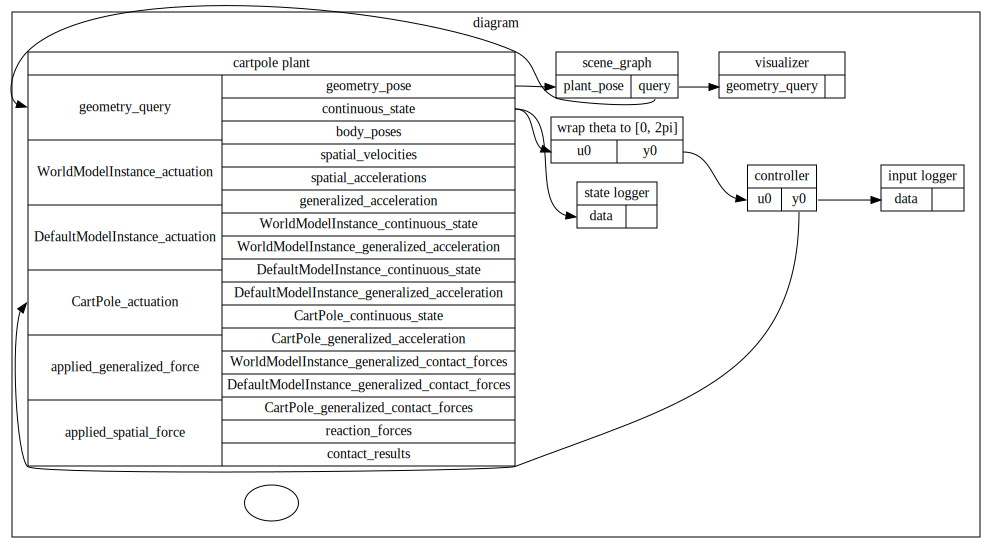

In [4]:
def fitted_value_iteration(
    num_samples={"x": 10, "theta": 50, "x_dot": 10, "theta_dot": 10},
    ranges={
        "x": (-2, 2),
        "theta": (0, 2 * np.pi),
        "x_dot": (-5, 5),
        "theta_dot": (-5, 5),
    },
    input_limit=3,
    num_inputs=50,
    target_state={"x": 0, "theta": np.pi, "x_dot": 0, "theta_dot": 0},
    time_step=0.01,
):
    input_port = 3
    Q = np.diag([0.1, 20, 1, 1])
    R = np.diag([2])

    plant, _, _ = create_cartpole()
    simulator = Simulator(plant)

    state_space = create_state_space(num_samples, ranges, target_state)
    pandas_grid = create_pandas_grid(state_space)
    state_grid = [set(v) for v in state_space.values()]
    input_grid = [set(np.append(np.linspace(-input_limit, input_limit, num_inputs), 0))]

    def quadratic_cost(Q, R, target_state):
        def cost(context):
            state = context.get_continuous_state_vector().CopyToVector()
            x = state - target_state
            u = plant.EvalVectorInput(context, input_port).CopyToVector()
            return np.einsum("x,xx,x", x, Q, x) + np.einsum("u,uu,u", u, R, u)

        return cost

    options = DynamicProgrammingOptions()
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(1, 0, 2 * np.pi),
    ]
    options.discount_factor = 0.9999
    options.convergence_tol = 0.1
    options.input_port_index = plant.get_input_port(input_port).get_index()

    policy, cost_to_go = FittedValueIteration(
        simulator,
        quadratic_cost(Q, R, list(target_state.values())),
        state_grid,
        input_grid,
        time_step,
        options,
    )
    pandas_grid["J"] = cost_to_go
    pandas_grid["policy"] = policy.get_output_values().flatten()

    return policy, cost_to_go, pandas_grid


policy, simple_cost_to_go, simple_states = fitted_value_iteration(input_limit=60)


def build_simulation(policy):
    # initialize builder
    builder = DiagramBuilder()

    # add cartpole
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelFromFile("cartpole.urdf")
    plant.Finalize()
    plant.CreateDefaultContext()
    plant.set_name("cartpole plant")

    # add the controller
    wrap = builder.AddSystem(WrapToSystem(4))
    wrap.set_name("wrap theta to [0, 2pi]")
    wrap.set_interval(1, 0, 2 * np.pi)
    controller = builder.AddSystem(policy)
    controller.set_name("controller")

    builder.Connect(plant.get_state_output_port(), wrap.get_input_port())
    builder.Connect(wrap.get_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    # Add visualizer
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-3.0, 3.0], ylim=[-0.5, 1.2], show=False
        )
    )
    visualizer.set_name("visualizer")
    builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))

    # Add loggers
    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)
    state_logger.set_name("state logger")

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    input_logger.set_name("input logger")

    # Build the diagram
    diagram = builder.Build()
    diagram.set_name("diagram")

    # Simulate
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False)  # makes sim faster

    return visualizer, simulator, diagram, state_logger, input_logger


visualizer, simulator, diagram, state_logger, input_logger = build_simulation(policy)
visualize_system(diagram)

In [ ]:
df = simulate_and_animate(
    {"x": 0, "theta": 0, "x_dot": 0, "theta_dot": 0},
    visualizer,
    simulator,
    state_logger,
    input_logger,
    sim_time=30
)

In [ ]:
base_chart = alt.Chart(df).encode(
    alt.X("time:Q", title="Time (s)"),
)
input_chart = base_chart.mark_line(color="orange").encode(
    alt.Y("u:Q", title="Torque (Nm)", axis=alt.Axis(titleColor="orange")),
)
state_chart = base_chart.mark_line().encode(
    alt.Y("theta:Q", title="Theta (rad)"),
)
alt.layer(input_chart, state_chart).resolve_scale(y="independent")

In [ ]:
plot_surface(
    simple_states[
        (simple_states["theta"] == np.pi) & (simple_states["theta_dot"] == 0)
    ],
    {"name": "x", "is_angle": False},
    {"name": "x_dot", "is_angle": False},
    "J",
)

In [ ]:
plot_surface(
    simple_states[
        (simple_states["theta"] == np.pi) & (simple_states["theta_dot"] == 0)
    ],
    {"name": "x", "is_angle": False},
    {"name": "x_dot", "is_angle": False},
    "policy",
    color="vlag",
)

In [ ]:
plot_surface(
    simple_states[(simple_states["x"] == 0) & (simple_states["x_dot"] == 0)],
    {"name": "theta", "is_angle": True},
    {"name": "theta_dot", "is_angle": False},
    "J",
)

In [ ]:
plot_surface(
    simple_states[(simple_states["x"] == 0) & (simple_states["x_dot"] == 0)],
    {"name": "theta", "is_angle": True},
    {"name": "theta_dot", "is_angle": False},
    "policy",
    color="vlag",
)

# Cartpole Neural Net Training

'loss: 9.97846e-05 epoch: 299/300'

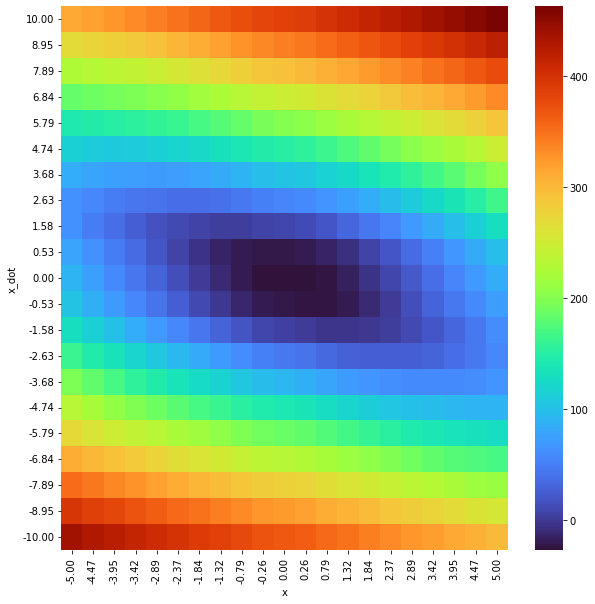

In [3]:
Q = np.diag([0.1, 20, 1, 1])
R = np.array([0.01])


def train_cart_pole(
    num_samples={"x": 20, "theta": 50, "x_dot": 20, "theta_dot": 20},
    ranges={
        "x": (-5, 5),
        "theta": (0, 2 * np.pi),
        "x_dot": (-10, 10),
        "theta_dot": (-10, 10),
    },
    lr=1e-4,
    epochs=300,
    steps_per_epoch=100,
    target_state={"x": 0.0, "theta": np.pi, "x_dot": 0.0, "theta_dot": 0.0},
    discount_factor=0.999,
):
    # Create the plant
    plant, context, _ = create_cartpole()

    # Create a state space grid, ensuring that the target state is included
    states = create_state_space(num_samples, ranges, target_state)
    state_grid_cart = np.meshgrid(*states.values(), indexing="ij")
    state_grid = np.vstack([s.flatten() for s in state_grid_cart])

    # zero cost state
    target_state = np.array([v for v in target_state.values()]).reshape(-1, 1)

    # A neural network for the cartpole
    mlp = MultilayerPerceptron(
        [False, True, False, False],
        [164, 164, 1],
        [
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kIdentity,
        ],
    )

    # train the neural network
    mlp_context, loss_over_time = ContinuousFittedValueIteration(
        plant,
        context,
        mlp,
        partial(compute_state_cost, Q, target_state),
        compute_u_star,
        R,
        state_grid,
        target_state,
        time_step=0.01,
        discount_factor=discount_factor,
        lr=lr,
        minibatch=32,
        epochs=epochs,
        optimization_steps_per_epoch=steps_per_epoch,
        input_limits=None,
    )

    states = create_pandas_grid(states)
    states["J"] = mlp.BatchOutput(mlp_context, state_grid)[0]

    return mlp, mlp_context, loss_over_time, states


mlp, mlp_context, loss_over_time, states = train_cart_pole()
plot_surface(
    states[(states["theta"] == np.pi) & (states["theta_dot"] == 0)],
    {"name": "x", "is_angle": False},
    {"name": "x_dot", "is_angle": False},
    "J",
)

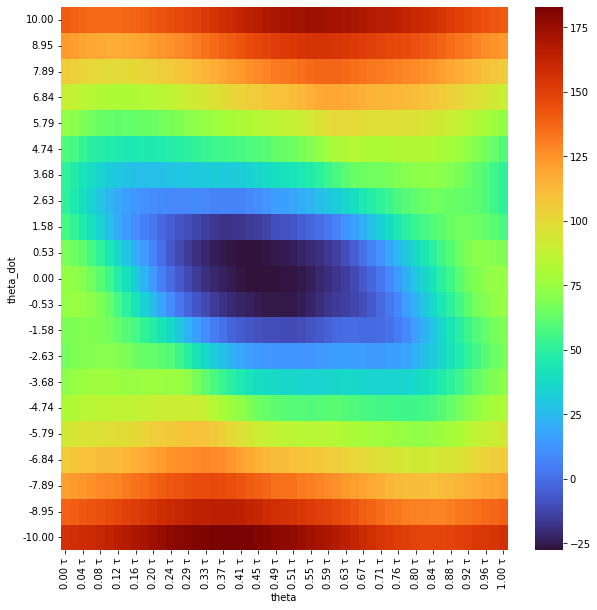

In [4]:
plot_surface(
    states[(states["x"] == 0) & (states["x_dot"] == 0)],
    {"name": "theta", "is_angle": True},
    {"name": "theta_dot", "is_angle": False},
    "J",
)

# Cartpole Neural Net Controller Simulation

In [12]:
def simulate_and_animate(
    starting_state,
    visualizer,
    simulator,
    state_logger=None,
    input_logger=None,
    sim_time=5,
):
    """
    Simulate the system and produce a video

    Return a dataframe containing the state and input over time
    """

    visualizer.start_recording()

    context = simulator.get_mutable_context()
    context.SetTime(0.0)
    context.SetContinuousState(np.array(list(starting_state.values())))

    if state_logger is not None and input_logger is not None:
        state_logger.FindMutableLog(context).Clear()
        input_logger.FindMutableLog(context).Clear()

    simulator.Initialize()
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(sim_time)

    visualizer.stop_recording()

    ani = visualizer.get_recording_as_animation()
    ani.save("animation.mp4", fps=30)

    display(HTML(ani.to_jshtml()))
    visualizer.reset_recording()

    if state_logger is not None and input_logger is not None:
        state_log = state_logger.FindLog(simulator.get_context())
        input_log = input_logger.FindLog(simulator.get_context())

        state_names = list(starting_state.keys())
        df = pd.DataFrame(state_log.data().T, columns=state_names)
        df["time"] = state_log.sample_times()
        df["u"] = input_log.data().T

        return df

def control_cart_pole():
    builder = DiagramBuilder()

    # Create the cart-pole
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelFromFile("cartpole.urdf")
    plant.Finalize()
    plant.CreateDefaultContext()
    plant.set_name("Cart-pole")

    # Create the controller
    neural_net_policy = ContinuousFittedValueIterationPolicy(
        plant,
        mlp,
        mlp_context,
        R,
        compute_u_star,
    )
    controller = builder.AddSystem(neural_net_policy)
    controller.set_name("Neural net controller")
    time_step = 0.01
    zoh = builder.AddSystem(
        ZeroOrderHold(time_step, 1)
    )  # we assume a zero-order hold between time steps
    zoh.set_name("Zero-order hold")
    wrap = builder.AddSystem(WrapToSystem(4))
    wrap.set_name("wrap theta to [0, 2pi]")
    wrap.set_interval(1, 0, 2 * np.pi)
    builder.Connect(plant.get_state_output_port(), wrap.get_input_port())
    builder.Connect(wrap.get_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), zoh.get_input_port())
    builder.Connect(zoh.get_output_port(), plant.get_actuation_input_port())

    # Add the visualizer
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-3.0, 3.0], ylim=[-0.5, 1.2], show=False
        )
    )
    builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))

    # Add loggers
    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)
    state_logger.set_name("state logger")

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    input_logger.set_name("input logger")

    # Simulate
    simulator = Simulator(builder.Build())

    return simulate_and_animate(
        {"x": 0, "theta": 0, "x_dot": 0, "theta_dot": 0},
        visualizer,
        simulator,
        state_logger,
        input_logger,
        sim_time=7,
    )


df = control_cart_pole()
base_chart = alt.Chart(df).encode(
    alt.X("time:Q", title="Time (s)"),
)
input_chart = base_chart.mark_line(color="orange").encode(
    alt.Y("u:Q", title="Force (N)", axis=alt.Axis(titleColor="orange")),
)
state_chart = base_chart.mark_line().encode(
    alt.Y("theta:Q", title="Theta (rad)"),
)
alt.layer(input_chart, state_chart).resolve_scale(y="independent").properties(
    width=1000,
    height=800,
).configure_legend(labelFontSize=20)

alt.LayerChart(...)

In [16]:
base_chart = alt.Chart(df).encode(
    alt.X("time:Q", title="Time (s)"),
)
input_chart = base_chart.mark_line(color="orange").encode(
    alt.Y("u:Q", title="Force (N)", axis=alt.Axis(titleColor="orange")),
)
state_chart = base_chart.mark_line().encode(
    alt.Y("theta:Q", title="Theta (rad)"),
)
alt.layer(input_chart, state_chart).resolve_scale(y="independent").properties(
    width=1000,
    height=800,
).configure_axis(labelFontSize=20, titleFontSize=20)

alt.LayerChart(...)

# Test with fixed input controller

In [ ]:
def simulate_fixed_input_controller():
    # initialize plant
    diagram_builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(diagram_builder, time_step=0.0)
    Parser(plant).AddModelFromFile("cartpole.urdf")
    plant.Finalize()

    # Add visualizer
    visualizer = diagram_builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-3.0, 3.0], ylim=[-0.5, 1.2], show=False
        )
    )
    diagram_builder.Connect(
        scene_graph.get_query_output_port(), visualizer.get_input_port(0)
    )

    # set up simulator
    diagram = diagram_builder.Build()
    simulator = Simulator(diagram)
    simulator_context = simulator.get_mutable_context()

    # setup input
    fixed_input = np.array([10])
    plant_context = diagram.GetMutableSubsystemContext(plant, simulator_context)
    plant.get_actuation_input_port().FixValue(plant_context, fixed_input)

    simulate_and_animate(
        {"x": -2, "theta": np.pi, "x_dot": 0, "theta_dot": 0},
        visualizer,
        simulator,
    )


simulate_fixed_input_controller()

# Pendulum training

In [ ]:
PENDULUM_TORQUE_LIMIT = 2


def train_pendulum(
    num_samples={"theta": 40, "theta_dot": 40},
    epochs=150,
    ranges={"theta": (0, 2 * np.pi), "theta_dot": (-10, 10)},
    target_state={"theta": np.pi, "theta_dot": 0.0},
    discount_factor=0.999,
    torque_limit=3,
    Q=np.diag([10, 1]),
):
    R = np.array([1])

    # Create the pendulum
    plant = PendulumPlant()
    plant_context = plant.CreateDefaultContext()

    # Create the state grid
    states = create_state_space(num_samples, ranges, target_state)
    state_grid = np.meshgrid(*states.values(), indexing="ij")
    state_samples = np.vstack([s.flatten() for s in state_grid])

    # zero cost state
    target_state = np.array([v for v in target_state.values()]).reshape(-1, 1)

    # A neural network for the cartpole
    mlp = MultilayerPerceptron(
        # whether to send input i to cos(x_i), sin(x_i)
        [True, False],
        [164, 164, 1],
        [
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kIdentity,
        ],
    )

    # train the neural network
    mlp_context, loss_over_time = ContinuousFittedValueIteration(
        plant,
        plant_context,
        mlp,
        partial(compute_state_cost, Q, target_state),
        compute_u_star,
        R,
        state_samples,
        target_state,
        time_step=0.01,
        discount_factor=discount_factor,
        lr=1e-4,
        minibatch=32,
        epochs=epochs,
        optimization_steps_per_epoch=100,
        input_limits=[-torque_limit, torque_limit],
    )
    df = create_pandas_grid(states)
    df["J"] = mlp.BatchOutput(mlp_context, state_samples)[0]

    return mlp, mlp_context, loss_over_time, df


mlp, mlp_context, loss_over_time, df = train_pendulum(
    torque_limit=PENDULUM_TORQUE_LIMIT,
    epochs=150,
    discount_factor=0.999,
    Q=np.diag([20, 1]),
)
plot_surface(
    df,
    {"name": "theta", "is_angle": True},
    {"name": "theta_dot", "is_angle": False},
    "J",
)

# Pendulum input controller

In [ ]:
def control_pendulum(torque_limit=3, sim_time=4):
    R = np.array([1])
    builder = DiagramBuilder()

    # Create the pendulum
    scene_graph = builder.AddSystem(SceneGraph())
    plant = builder.AddSystem(PendulumPlant())
    PendulumGeometry.AddToBuilder(builder, plant.get_state_output_port(), scene_graph)

    policy = ContinuousFittedValueIterationPolicy(
        plant,
        mlp,
        mlp_context,
        R,
        compute_u_star,
        input_limits=[-torque_limit, torque_limit],
    )

    controller = builder.AddSystem(policy)
    # we assume a zero-order hold between time steps
    time_step = 0.01
    zoh_cart = builder.AddSystem(ZeroOrderHold(time_step, 1))

    # wire all the systems together
    wrap = builder.AddSystem(WrapToSystem(2))
    wrap.set_name("wrap theta to [0, 2pi]")
    wrap.set_interval(0, 0, 2 * np.pi)
    builder.Connect(plant.get_state_output_port(), wrap.get_input_port())
    builder.Connect(wrap.get_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), zoh_cart.get_input_port())
    builder.Connect(zoh_cart.get_output_port(), plant.get_input_port(0))

    # Add visualizer
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-1.2, 1.2], ylim=[-1.2, 1.2], show=False
        )
    )
    builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))

    # Add loggers
    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)
    state_logger.set_name("state logger")

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    input_logger.set_name("input logger")

    # Simulate
    simulator = Simulator(builder.Build())
    simulator.set_publish_every_time_step(False)  # makes sim faster

    return simulate_and_animate(
        {"theta": 0, "theta_dot": 0},
        visualizer,
        simulator,
        state_logger,
        input_logger,
        sim_time=sim_time,
    )


df = control_pendulum(torque_limit=PENDULUM_TORQUE_LIMIT)
base_chart = alt.Chart(df).encode(
    alt.X("time:Q", title="Time (s)"),
)
input_chart = base_chart.mark_line(color="orange").encode(
    alt.Y("u:Q", title="Torque (Nm)", axis=alt.Axis(titleColor="orange")),
)
state_chart = base_chart.mark_line().encode(
    alt.Y("theta:Q", title="Theta (rad)"),
)
alt.layer(input_chart, state_chart).resolve_scale(y="independent")